**g16**
- anderdav@students.zhaw.ch
- goodnic1@students.zhaw.ch
- janick.rueegger@students.fhnw.ch
- neyerjoh@students.zhaw.ch

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch import nn
from torchinfo import summary
from torch.utils.data import DataLoader, TensorDataset
from tqdm.notebook import tqdm

In [2]:
with open("companies.csv") as corpus_file:
    corpus = corpus_file.read().replace("\n", "")
    corpus_length = len(corpus)
    
print(f"Loaded a corpus of {corpus_length} characters")

Loaded a corpus of 2395500 characters


In [3]:
chars = sorted(list(set(corpus)))
num_chars = len(chars)
encoding = {c: i for i, c in enumerate(chars)}
decoding = {i: c for i, c in enumerate(chars)}
print("Our corpus contains {0} unique characters.".format(num_chars))

Our corpus contains 149 unique characters.


In [4]:
print(encoding)
print(decoding)

{' ': 0, '!': 1, '"': 2, '#': 3, '$': 4, '%': 5, '&': 6, "'": 7, '(': 8, ')': 9, '*': 10, '+': 11, ',': 12, '-': 13, '.': 14, '/': 15, '0': 16, '1': 17, '2': 18, '3': 19, '4': 20, '5': 21, '6': 22, '7': 23, '8': 24, '9': 25, ':': 26, '=': 27, '>': 28, '?': 29, '@': 30, 'A': 31, 'B': 32, 'C': 33, 'D': 34, 'E': 35, 'F': 36, 'G': 37, 'H': 38, 'I': 39, 'J': 40, 'K': 41, 'L': 42, 'M': 43, 'N': 44, 'O': 45, 'P': 46, 'Q': 47, 'R': 48, 'S': 49, 'T': 50, 'U': 51, 'V': 52, 'W': 53, 'X': 54, 'Y': 55, 'Z': 56, '[': 57, '\\': 58, ']': 59, '^': 60, '_': 61, 'a': 62, 'b': 63, 'c': 64, 'd': 65, 'e': 66, 'f': 67, 'g': 68, 'h': 69, 'i': 70, 'j': 71, 'k': 72, 'l': 73, 'm': 74, 'n': 75, 'o': 76, 'p': 77, 'q': 78, 'r': 79, 's': 80, 't': 81, 'u': 82, 'v': 83, 'w': 84, 'x': 85, 'y': 86, 'z': 87, '{': 88, '|': 89, '}': 90, '~': 91, '\x81': 92, '\x82': 93, '\x83': 94, '\x84': 95, '\x85': 96, '\x86': 97, '\x87': 98, '\x88': 99, '\x89': 100, '\x8a': 101, '\x8b': 102, '\x8c': 103, '\x8d': 104, '\x8e': 105, '\x8f'

In [5]:
sequence_length = 10
#skip = 6
skip = 3

def encode_corpus(mm=False):
    X_data = []
    y_data = []
    for i in range (0, len(corpus) - sequence_length, skip):
        sequence = corpus[i:i+sequence_length]
        X_data.append([encoding[char] for char in sequence])
        if mm:
            next_char = corpus[i+1:i+sequence_length+1]
            y_data.append([encoding[char] for char in next_char])
        else:
            next_char = corpus[i+sequence_length]
            y_data.append(encoding[next_char])

    num_sequences = len(X_data)
    print(f"Sliced our corpus into {num_sequences} sequences of length {sequence_length}")
    
    print(X_data[0])
    print([decoding[c] for c in X_data[0]])
    if mm:
        print([decoding[idx] for idx in y_data[0]])
    else:
        print(decoding[y_data[0]])
    
    X = F.one_hot(torch.tensor(X_data), num_classes=num_chars).to(torch.float)
    y = torch.tensor(y_data)

    print(f"# sequences: {num_sequences}")
    print(f"Characters in corpus: {len(chars)}")
    print(f"sequence length: {sequence_length}")
    print(f"Sanity check y. Dimension: {y.shape}")
    print(f"Sanity check X. Dimension: {X.shape}")
    
    return X, y

In [6]:
def train(epoch, model, data_loader, criterion, mm=False, log_interval=2000):
    model.train()
    total_train_loss = 0
    total_correct = 0 

    for batch_idx, (data, target) in enumerate(tqdm(data_loader, desc=f"Training Epoch {epoch}")):
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad() 

        output = model(data)

        if mm:
            output = output.transpose(1, 2) 
        
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
        
        _, pred = torch.max(output, dim=1)

        total_correct += torch.sum(pred == target).item()

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(data_loader.dataset),
                100. * batch_idx / len(data_loader), loss.data.item()))
    
    accuracy_train = total_correct / len(data_loader.dataset)
    
    total_train_loss = total_train_loss / len(data_loader)

    return {
        "loss": total_train_loss,
        "accuracy": accuracy_train,
    }

In [7]:
def make_seed(seed_phrase=""):
        if seed_phrase:
            phrase_length = len(seed_phrase)
            pattern = ""
            for i in range (0, sequence_length):
                pattern += seed_phrase[i % phrase_length]
        else:
            seed = random.randint(0, corpus_length - sequence_length)
            pattern = corpus[seed:seed + sequence_length]
        return pattern

def generate_text(model, mm=False, seed_phrase="", length=20):
    seed_pattern = make_seed(seed_phrase)
    print(f"seed = {seed_pattern}")

    encoded_text = torch.tensor([encoding[char] for char in seed_pattern])
    encoded_text = F.one_hot(encoded_text, num_classes=num_chars).to(torch.float)
    encoded_text = encoded_text.unsqueeze(0)
    encoded_text = encoded_text.to(device)

    generated_text = ""
    for i in range(length):        
        output = predict(model, encoded_text).squeeze()
        
        if mm:
            output = output[-1]

        probs = torch.softmax(output, dim=-1)
        prediction = torch.multinomial(probs, num_samples=1)
        generated_text += decoding[int(prediction)]

        next_char_encoded = F.one_hot(prediction, num_classes=num_chars)
        next_char_encoded = next_char_encoded.view(1, 1, num_chars)
        encoded_text = torch.cat((encoded_text[:, 1:], next_char_encoded), dim=1)

    print(generated_text)

In [8]:
@torch.inference_mode() 
def predict(model, data):
    model.eval()
    output = model(data)
    return output

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
batch_size = 128
num_classes = num_chars

In [11]:
layer_size = 1
hidden_size = 64
epochs = 10

## Many to One  approach

In [12]:
X, y = encode_corpus()
dataset = TensorDataset(X, y)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

Sliced our corpus into 798497 sequences of length 10
[38, 62, 80, 69, 77, 73, 62, 86, 0, 39]
['H', 'a', 's', 'h', 'p', 'l', 'a', 'y', ' ', 'I']
n
# sequences: 798497
Characters in corpus: 149
sequence length: 10
Sanity check y. Dimension: torch.Size([798497])
Sanity check X. Dimension: torch.Size([798497, 10, 149])


In [13]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, layer_size, num_classes):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, layer_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:, -1]
        out = self.fc(out)
        return out

In [14]:
model = RNNModel(num_classes, hidden_size, layer_size, num_classes).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

summary(model, input_size=(batch_size, sequence_length, num_classes))

Layer (type:depth-idx)                   Output Shape              Param #
RNNModel                                 --                        --
├─RNN: 1-1                               [128, 10, 64]             13,760
├─Linear: 1-2                            [128, 149]                9,685
Total params: 23,445
Trainable params: 23,445
Non-trainable params: 0
Total mult-adds (M): 18.85
Input size (MB): 0.76
Forward/backward pass size (MB): 0.81
Params size (MB): 0.09
Estimated Total Size (MB): 1.66

In [15]:
model

RNNModel(
  (rnn): RNN(149, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=149, bias=True)
)

In [16]:
%%time

train_losses = []
train_accuracies = []

for epoch in range(1, epochs + 1):
    train_result = train(epoch, model, train_loader, criterion)
    train_losses.append(train_result["loss"])
    train_accuracies.append(train_result["accuracy"])

Training Epoch 1:   0%|          | 0/6239 [00:00<?, ?it/s]

Train Epoch: 1 [0/798497 (0%)]	Loss: 5.025196
Train Epoch: 1 [256000/798497 (32%)]	Loss: 2.661633
Train Epoch: 1 [512000/798497 (64%)]	Loss: 2.595524
Train Epoch: 1 [768000/798497 (96%)]	Loss: 2.603678


Training Epoch 2:   0%|          | 0/6239 [00:00<?, ?it/s]

Train Epoch: 2 [0/798497 (0%)]	Loss: 2.506309
Train Epoch: 2 [256000/798497 (32%)]	Loss: 2.463049
Train Epoch: 2 [512000/798497 (64%)]	Loss: 2.439331
Train Epoch: 2 [768000/798497 (96%)]	Loss: 2.478030


Training Epoch 3:   0%|          | 0/6239 [00:00<?, ?it/s]

Train Epoch: 3 [0/798497 (0%)]	Loss: 2.520513
Train Epoch: 3 [256000/798497 (32%)]	Loss: 2.612039
Train Epoch: 3 [512000/798497 (64%)]	Loss: 2.412429
Train Epoch: 3 [768000/798497 (96%)]	Loss: 1.946478


Training Epoch 4:   0%|          | 0/6239 [00:00<?, ?it/s]

Train Epoch: 4 [0/798497 (0%)]	Loss: 2.239796
Train Epoch: 4 [256000/798497 (32%)]	Loss: 2.090056
Train Epoch: 4 [512000/798497 (64%)]	Loss: 2.478755
Train Epoch: 4 [768000/798497 (96%)]	Loss: 2.209380


Training Epoch 5:   0%|          | 0/6239 [00:00<?, ?it/s]

Train Epoch: 5 [0/798497 (0%)]	Loss: 2.471653
Train Epoch: 5 [256000/798497 (32%)]	Loss: 2.350351
Train Epoch: 5 [512000/798497 (64%)]	Loss: 2.186775
Train Epoch: 5 [768000/798497 (96%)]	Loss: 2.484632


Training Epoch 6:   0%|          | 0/6239 [00:00<?, ?it/s]

Train Epoch: 6 [0/798497 (0%)]	Loss: 2.301552
Train Epoch: 6 [256000/798497 (32%)]	Loss: 2.120352
Train Epoch: 6 [512000/798497 (64%)]	Loss: 2.627101
Train Epoch: 6 [768000/798497 (96%)]	Loss: 2.564474


Training Epoch 7:   0%|          | 0/6239 [00:00<?, ?it/s]

Train Epoch: 7 [0/798497 (0%)]	Loss: 2.118208
Train Epoch: 7 [256000/798497 (32%)]	Loss: 2.295676
Train Epoch: 7 [512000/798497 (64%)]	Loss: 2.329563
Train Epoch: 7 [768000/798497 (96%)]	Loss: 2.212686


Training Epoch 8:   0%|          | 0/6239 [00:00<?, ?it/s]

Train Epoch: 8 [0/798497 (0%)]	Loss: 2.113772
Train Epoch: 8 [256000/798497 (32%)]	Loss: 2.162413
Train Epoch: 8 [512000/798497 (64%)]	Loss: 2.178134
Train Epoch: 8 [768000/798497 (96%)]	Loss: 2.376977


Training Epoch 9:   0%|          | 0/6239 [00:00<?, ?it/s]

Train Epoch: 9 [0/798497 (0%)]	Loss: 2.330796
Train Epoch: 9 [256000/798497 (32%)]	Loss: 2.191081
Train Epoch: 9 [512000/798497 (64%)]	Loss: 2.392605
Train Epoch: 9 [768000/798497 (96%)]	Loss: 1.982239


Training Epoch 10:   0%|          | 0/6239 [00:00<?, ?it/s]

Train Epoch: 10 [0/798497 (0%)]	Loss: 2.222318
Train Epoch: 10 [256000/798497 (32%)]	Loss: 2.191767
Train Epoch: 10 [512000/798497 (64%)]	Loss: 2.270031
Train Epoch: 10 [768000/798497 (96%)]	Loss: 2.116846
CPU times: user 12min 50s, sys: 1.44 s, total: 12min 52s
Wall time: 2min 9s


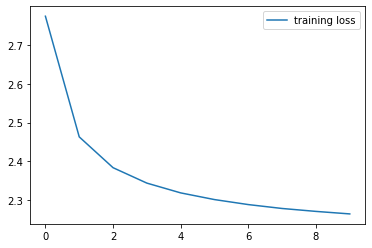

In [17]:
plt.plot(train_losses, label="training loss")
plt.legend()

In [36]:
generate_text(model, length=1000)

seed =  EyesRetai
lines Carmicolion CorperaticsDeckepCapec Ra, LLC"Moxha ThiteSivancedeRonan BlowGefis VICERAGFiRPharesEyporans AASPoyTecExhoroPorityPharkCollon G. Instraching PussnosConterUPOneeHaxesth TechnologyVistria Energy ReseamoksPmhida SolationPhteze TheriaMediesFashor SoftwareSprassoreWeb (EugonnPoindCill CaneCarindCam- AficsQlikingy InforationsSafoWelyIurxPient Lominel ConsurtadersContStuluwnonDal PanorectsRevandent PharmaceuticalsSolve GrodJ GanfingDaGime.comOnRextropeetEquary, Inc."Sate CorparitechProDack Medial Resown c.ilinionLaidInsite.ficing CorpheretionFrovereGokibrel OVOFEnshern PharmantsWoinl GroupPharpGardfor Systomy Communitics Health CoBiescysers, Inc."vi Pharmiging Medical Systems Purtochime Mofice - TxGGIFTwhothew Intedrationonieflty FatingGingisWipoplascStultingNovaid4FourHoutd HoldingsOlfanTacchouketa DatagoniVenambeatiNernuifor Search TreationalIIStrivbrage LRafity Eass Interactagnor PharmpriceDittelZFynaraCape MonicationCodlol GombFarm My Dation Alaj Broondf

## Many to many approach

In [19]:
X, y = encode_corpus(mm=True)
dataset = TensorDataset(X, y)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

Sliced our corpus into 798497 sequences of length 10
[38, 62, 80, 69, 77, 73, 62, 86, 0, 39]
['H', 'a', 's', 'h', 'p', 'l', 'a', 'y', ' ', 'I']
['a', 's', 'h', 'p', 'l', 'a', 'y', ' ', 'I', 'n']
# sequences: 798497
Characters in corpus: 149
sequence length: 10
Sanity check y. Dimension: torch.Size([798497, 10])
Sanity check X. Dimension: torch.Size([798497, 10, 149])


In [20]:
class mmRNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, layer_size, num_classes):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, layer_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        out, _ = self.rnn(x)

        # Don't include hidden state when not training
        if not self.train:
            out = out[:, -1]

        out = self.fc(out)
        return out

In [21]:
modelmm = mmRNNModel(num_classes, hidden_size, layer_size, num_classes).to(device)

optimizer = torch.optim.Adam(modelmm.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

summary(modelmm, input_size=(batch_size, sequence_length, num_classes))

Layer (type:depth-idx)                   Output Shape              Param #
mmRNNModel                               --                        --
├─RNN: 1-1                               [128, 10, 64]             13,760
├─Linear: 1-2                            [128, 10, 149]            9,685
Total params: 23,445
Trainable params: 23,445
Non-trainable params: 0
Total mult-adds (M): 18.85
Input size (MB): 0.76
Forward/backward pass size (MB): 2.18
Params size (MB): 0.09
Estimated Total Size (MB): 3.04

In [22]:
modelmm

mmRNNModel(
  (rnn): RNN(149, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=149, bias=True)
)

In [23]:
%%time

train_losses = []
train_accuracies = []

for epoch in range(1, epochs + 1):
    train_result = train(epoch, modelmm, train_loader, criterion, mm=True)
    train_losses.append(train_result["loss"])
    train_accuracies.append(train_result["accuracy"])

Training Epoch 1:   0%|          | 0/6239 [00:00<?, ?it/s]

Train Epoch: 1 [0/798497 (0%)]	Loss: 4.980816
Train Epoch: 1 [256000/798497 (32%)]	Loss: 2.643917
Train Epoch: 1 [512000/798497 (64%)]	Loss: 2.566518
Train Epoch: 1 [768000/798497 (96%)]	Loss: 2.475399


Training Epoch 2:   0%|          | 0/6239 [00:00<?, ?it/s]

Train Epoch: 2 [0/798497 (0%)]	Loss: 2.489285
Train Epoch: 2 [256000/798497 (32%)]	Loss: 2.546960
Train Epoch: 2 [512000/798497 (64%)]	Loss: 2.464510
Train Epoch: 2 [768000/798497 (96%)]	Loss: 2.443211


Training Epoch 3:   0%|          | 0/6239 [00:00<?, ?it/s]

Train Epoch: 3 [0/798497 (0%)]	Loss: 2.302392
Train Epoch: 3 [256000/798497 (32%)]	Loss: 2.437225
Train Epoch: 3 [512000/798497 (64%)]	Loss: 2.408682
Train Epoch: 3 [768000/798497 (96%)]	Loss: 2.555608


Training Epoch 4:   0%|          | 0/6239 [00:00<?, ?it/s]

Train Epoch: 4 [0/798497 (0%)]	Loss: 2.506809
Train Epoch: 4 [256000/798497 (32%)]	Loss: 2.340906
Train Epoch: 4 [512000/798497 (64%)]	Loss: 2.461182
Train Epoch: 4 [768000/798497 (96%)]	Loss: 2.244144


Training Epoch 5:   0%|          | 0/6239 [00:00<?, ?it/s]

Train Epoch: 5 [0/798497 (0%)]	Loss: 2.470629
Train Epoch: 5 [256000/798497 (32%)]	Loss: 2.194165
Train Epoch: 5 [512000/798497 (64%)]	Loss: 2.345688
Train Epoch: 5 [768000/798497 (96%)]	Loss: 2.328707


Training Epoch 6:   0%|          | 0/6239 [00:00<?, ?it/s]

Train Epoch: 6 [0/798497 (0%)]	Loss: 2.390932
Train Epoch: 6 [256000/798497 (32%)]	Loss: 2.360533
Train Epoch: 6 [512000/798497 (64%)]	Loss: 2.291035
Train Epoch: 6 [768000/798497 (96%)]	Loss: 2.352936


Training Epoch 7:   0%|          | 0/6239 [00:00<?, ?it/s]

Train Epoch: 7 [0/798497 (0%)]	Loss: 2.405091
Train Epoch: 7 [256000/798497 (32%)]	Loss: 2.372296
Train Epoch: 7 [512000/798497 (64%)]	Loss: 2.290192
Train Epoch: 7 [768000/798497 (96%)]	Loss: 2.487785


Training Epoch 8:   0%|          | 0/6239 [00:00<?, ?it/s]

Train Epoch: 8 [0/798497 (0%)]	Loss: 2.288990
Train Epoch: 8 [256000/798497 (32%)]	Loss: 2.282524
Train Epoch: 8 [512000/798497 (64%)]	Loss: 2.376785
Train Epoch: 8 [768000/798497 (96%)]	Loss: 2.299713


Training Epoch 9:   0%|          | 0/6239 [00:00<?, ?it/s]

Train Epoch: 9 [0/798497 (0%)]	Loss: 2.490554
Train Epoch: 9 [256000/798497 (32%)]	Loss: 2.452921
Train Epoch: 9 [512000/798497 (64%)]	Loss: 2.460905
Train Epoch: 9 [768000/798497 (96%)]	Loss: 2.407662


Training Epoch 10:   0%|          | 0/6239 [00:00<?, ?it/s]

Train Epoch: 10 [0/798497 (0%)]	Loss: 2.325625
Train Epoch: 10 [256000/798497 (32%)]	Loss: 2.389966
Train Epoch: 10 [512000/798497 (64%)]	Loss: 2.367251
Train Epoch: 10 [768000/798497 (96%)]	Loss: 2.473661
CPU times: user 17min 2s, sys: 1.35 s, total: 17min 3s
Wall time: 2min 50s


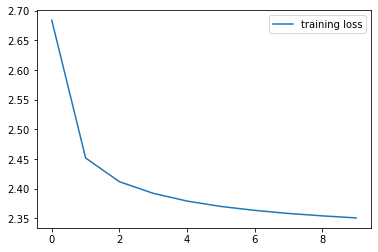

In [24]:
plt.plot(train_losses, label="training loss")
plt.legend()

In [35]:
generate_text(modelmm, length=1000, mm=True)

seed = MPAQUEEmpa
se ColieFistuse NathoreGOR A.Bet EteVolling Celpoa Alliok Swork TiptyStreet L: Entromas Vust NetworkGKeelEstimSG Granker Fount YoanketsClaburgVoipSundaWingDGrancefeGmP& Compinet TordingsAkel BitJ.RSSS RidFrokdeyCompower Divi DaytaliFliffi Outo Designald and NetworkDion RestiedCoshieDrwert, Inc""ChayweoShoisaseiBote-Gambrysia-MavadenStumiScrimioCelvagomIPEATTAM Sle LLCThersutsEnergy Sfroy.loTyken Intogic SolutionsVinderAllce CoupTechTexpEutphinitalAirnceInternation998ioBateSine HumlSwareWhSageleIntercation Industries ty KntaneZienistMetronixsLavRolecial NetworksRespinance Co., Inc."OnlobaxMotomicsIRPOP Softwap, Inc."l Octove ConmindsEnterfrickXilesCharmaDBerhioTrandMormacoadX HoysRebixNetBankloxHealthoreamaur, Inc"ProdiaSequinabScareMelic )t + Krpok BuzicTLI"RockebsGC puntioneisCoperton's Reci Ecerier Discurd Technology The Buste ShareRevergyV Trustern M'Hapul WeylbrableSkut SRetsFivattyliveRecGPhk+MorneMakit Group Managinanunic | AshimerGordingEverassia GroupPressQua

# LSTM

In [27]:
batch_size = 128
X, y = encode_corpus(mm=True)
dataset = TensorDataset(X, y)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

Sliced our corpus into 798497 sequences of length 10
[38, 62, 80, 69, 77, 73, 62, 86, 0, 39]
['H', 'a', 's', 'h', 'p', 'l', 'a', 'y', ' ', 'I']
['a', 's', 'h', 'p', 'l', 'a', 'y', ' ', 'I', 'n']
# sequences: 798497
Characters in corpus: 149
sequence length: 10
Sanity check y. Dimension: torch.Size([798497, 10])
Sanity check X. Dimension: torch.Size([798497, 10, 149])


In [28]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, layer_size, num_classes):
        super().__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, layer_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        out, _ = self.rnn(x)
        if not self.train:
            out = out[:, -1]
        out = self.fc(out)
        return out

In [29]:
modellstm = LSTMModel(num_classes, hidden_size, layer_size, num_classes).to(device)

optimizer = torch.optim.Adam(modellstm.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

summary(modellstm, input_size=(batch_size, sequence_length, num_classes))

Layer (type:depth-idx)                   Output Shape              Param #
LSTMModel                                --                        --
├─LSTM: 1-1                              [128, 10, 64]             55,040
├─Linear: 1-2                            [128, 10, 149]            9,685
Total params: 64,725
Trainable params: 64,725
Non-trainable params: 0
Total mult-adds (M): 71.69
Input size (MB): 0.76
Forward/backward pass size (MB): 2.18
Params size (MB): 0.26
Estimated Total Size (MB): 3.20

In [30]:
modellstm

LSTMModel(
  (rnn): LSTM(149, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=149, bias=True)
)

In [31]:
%%time

train_losses = []
train_accuracies = []

for epoch in range(1, epochs + 1):
    train_result = train(epoch, modellstm, train_loader, criterion, mm=True)
    train_losses.append(train_result["loss"])
    train_accuracies.append(train_result["accuracy"])

Training Epoch 1:   0%|          | 0/6239 [00:00<?, ?it/s]

Train Epoch: 1 [0/798497 (0%)]	Loss: 4.993733
Train Epoch: 1 [256000/798497 (32%)]	Loss: 2.840692
Train Epoch: 1 [512000/798497 (64%)]	Loss: 2.591230
Train Epoch: 1 [768000/798497 (96%)]	Loss: 2.614197


Training Epoch 2:   0%|          | 0/6239 [00:00<?, ?it/s]

Train Epoch: 2 [0/798497 (0%)]	Loss: 2.380610
Train Epoch: 2 [256000/798497 (32%)]	Loss: 2.482538
Train Epoch: 2 [512000/798497 (64%)]	Loss: 2.322880
Train Epoch: 2 [768000/798497 (96%)]	Loss: 2.411051


Training Epoch 3:   0%|          | 0/6239 [00:00<?, ?it/s]

Train Epoch: 3 [0/798497 (0%)]	Loss: 2.300907
Train Epoch: 3 [256000/798497 (32%)]	Loss: 2.251524
Train Epoch: 3 [512000/798497 (64%)]	Loss: 2.353773
Train Epoch: 3 [768000/798497 (96%)]	Loss: 2.117568


Training Epoch 4:   0%|          | 0/6239 [00:00<?, ?it/s]

Train Epoch: 4 [0/798497 (0%)]	Loss: 2.253027
Train Epoch: 4 [256000/798497 (32%)]	Loss: 2.078752
Train Epoch: 4 [512000/798497 (64%)]	Loss: 2.294012
Train Epoch: 4 [768000/798497 (96%)]	Loss: 2.343292


Training Epoch 5:   0%|          | 0/6239 [00:00<?, ?it/s]

Train Epoch: 5 [0/798497 (0%)]	Loss: 2.239264
Train Epoch: 5 [256000/798497 (32%)]	Loss: 2.293437
Train Epoch: 5 [512000/798497 (64%)]	Loss: 2.325787
Train Epoch: 5 [768000/798497 (96%)]	Loss: 2.327851


Training Epoch 6:   0%|          | 0/6239 [00:00<?, ?it/s]

Train Epoch: 6 [0/798497 (0%)]	Loss: 2.169950
Train Epoch: 6 [256000/798497 (32%)]	Loss: 2.222167
Train Epoch: 6 [512000/798497 (64%)]	Loss: 2.273507
Train Epoch: 6 [768000/798497 (96%)]	Loss: 2.177307


Training Epoch 7:   0%|          | 0/6239 [00:00<?, ?it/s]

Train Epoch: 7 [0/798497 (0%)]	Loss: 2.285927
Train Epoch: 7 [256000/798497 (32%)]	Loss: 2.217440
Train Epoch: 7 [512000/798497 (64%)]	Loss: 2.195410
Train Epoch: 7 [768000/798497 (96%)]	Loss: 2.206486


Training Epoch 8:   0%|          | 0/6239 [00:00<?, ?it/s]

Train Epoch: 8 [0/798497 (0%)]	Loss: 2.197697
Train Epoch: 8 [256000/798497 (32%)]	Loss: 2.284744
Train Epoch: 8 [512000/798497 (64%)]	Loss: 2.326726
Train Epoch: 8 [768000/798497 (96%)]	Loss: 2.237424


Training Epoch 9:   0%|          | 0/6239 [00:00<?, ?it/s]

Train Epoch: 9 [0/798497 (0%)]	Loss: 2.214446
Train Epoch: 9 [256000/798497 (32%)]	Loss: 2.345306
Train Epoch: 9 [512000/798497 (64%)]	Loss: 2.199571
Train Epoch: 9 [768000/798497 (96%)]	Loss: 2.246620


Training Epoch 10:   0%|          | 0/6239 [00:00<?, ?it/s]

Train Epoch: 10 [0/798497 (0%)]	Loss: 2.301910
Train Epoch: 10 [256000/798497 (32%)]	Loss: 2.246451
Train Epoch: 10 [512000/798497 (64%)]	Loss: 1.906939
Train Epoch: 10 [768000/798497 (96%)]	Loss: 2.204359
CPU times: user 36min 16s, sys: 7.96 s, total: 36min 24s
Wall time: 6min 10s


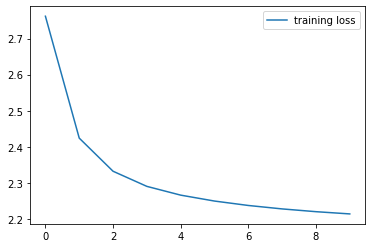

In [32]:
plt.plot(train_losses, label="training loss")
plt.legend()

In [33]:
generate_text(modellstm, length=10000, mm=True)

seed = tscape Mat
a AnalyticsEnviseLugic CurpThesumeorIlleadebriesNocratASURTABOPromixSturch Co.VidgeGln-yllo & BroaderTirrellVerviginAmmeraction Out MedKastienixFaurayjgry.LineFookeer TechnologiesMMC Muricar ENNOOT, LLCs.PD Recontrolie Sumply SolutionsBitold Reseurchnofymerse Wolder Healthcavitagi BioChrokMavevance SensticessMelish Designneq CorporationP Rockokigune.comToerShengi ved Solutions roduerochen Media Royerty PanOptieSociatesMeNEXT SystemsATemreClascoOMilenge IndustryGroupt TechnologiesAdemetriMetalPapp IndustriamDovers.coQuangotis FinancialUppro ProamingsMediaAxetricChoponera CommunicationsRithoSiderTraitualSwydeltykiStap GroupKingireHypart Mobile Management GroupThinchiver Beson Case MedicalsFRREPPO SaymentStazen's LebsAuto SciencesDePower ManagementBlacExfer Technologies, Inc."OTrireN1zbe LiveAsendy AssotiaMobiloulDawa Venture COL MyNehuAllera.FamerhaxAgromuna businessOntose Kninding)Qulrimon TechnologiesTaiTechnologiesAdvortle Health Whansarri2Intria SolutionseSen Cara R

# Findings

The number of RNN units (64 vs 128), epochs (10 vs 20) and layers (1 vs 2) don't seem to have significant influence. The generated names are of very similar quality.

The LSTM however generates better names. It also achieves slightly lower loss.

## Startup names

- TrustAnyuryOptec
- SolutionsThe
- TechnologiesFirst
- PVC Fimation
- ServicesPiXier
- Marmabaston Capital
- QuestmentsExpres Roadchblip Co.
- StonefaceuticalsElectroticTrining Corp
- MediaSightFirst
- Systems Center